# Generación de red de polinizadores

Instalación de pysant.

In [4]:
# ! pip install pystan

Paquetes necesarios.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utilities as ut
# import plant_pol_inference_pystan3 as pp
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

## Carga de datos

Datos de detecciones realizadas por YOLOv5.

In [2]:
# Leo el archivo test_yolo5m_v01.csv
df = pd.read_csv('test_yolov5m_v01.csv', sep=',', header=0)
# elimino las columnas xmin, ymin, xmax, ymax
df = df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)
display(df.head())
print(df.shape)

,imagen,categoría,deteccion
0,00068ee5e4632cf05be16306f00aa51b.jpg,Diptera,no_detection
1,0065808ec8a40acb4dbaf1a855045a1b.jpg,Bee,no_detection
2,00720ef5141a225e95a973c785e5292b.jpg,Bee,Wasp
3,00ad5ae0ef6fe82cad95e54e8f478857.jpg,Wasp,Wasp
4,01204afe7194a9a98cd57bb629877716.jpg,Bee,no_detection


(1926, 3)


Cargamos el archivo plants-bones.csv donde se encuentran las detecciones de plantas realizadas por la API de Plantnet. Cruzamos para solo tener la clasificación en familia.

In [3]:
# Leo el archivo plants-bones.csv
df_plantas = pd.read_csv('plants-bones.csv', sep=',', header=0)
# Leo el archivo EspeciesFamilia.csv
df_fam = pd.read_csv('EspecieFamilia.csv', sep=',', header=0)
# Uno los dos archivos
df_plantas = pd.merge(df_plantas, df_fam, on='id', how='left')
# elimino la columna nombres
df_plantas = df_plantas.drop(['nombres'], axis=1)
display(df_plantas.head())
print(df_plantas.shape)

,imagen,id,Familia
0,00068ee5e4632cf05be16306f00aa51b.jpg,Verbascum sinuatum L.,Scrophulariaceae
1,000f76f32b813c5429385c902a99f5d2.jpg,Daucus carota L.,Apiaceae
2,0065808ec8a40acb4dbaf1a855045a1b.jpg,Scabiosa atropurpurea L.,Dipsacaceae
3,00720ef5141a225e95a973c785e5292b.jpg,Ranunculus bulbosus L.,Ranunculaceae
4,00ad5ae0ef6fe82cad95e54e8f478857.jpg,NaN,NaN


(5445, 3)


Combino los dos dataframes para tener las detecciones de plantas y polinizadores en un solo dataframe.

In [ ]:
# Hago un merge de los dos dataframes
df1 = pd.merge(df, df_plantas, on='imagen', how='left')
# Elimino los NaN
df1 = df1.dropna(subset=['Familia'])
# Elimino la columna id
df1 = df1.drop(['id'], axis=1)
display(df1.head())
print(df1.shape)
# Guardo el archivo
df1.to_csv('TablaIncidencia.csv', index=False)

,imagen,categoría,deteccion,Familia
0,00068ee5e4632cf05be16306f00aa51b.jpg,Diptera,no_detection,Scrophulariaceae
1,0065808ec8a40acb4dbaf1a855045a1b.jpg,Bee,no_detection,Dipsacaceae
2,00720ef5141a225e95a973c785e5292b.jpg,Bee,Wasp,Ranunculaceae
4,01204afe7194a9a98cd57bb629877716.jpg,Bee,no_detection,Lamiaceae
5,013461eac6df1374f282d1678c79e26b.jpg,Bee,no_detection,Papaveraceae


(1110, 4)


Leemos la matriz de adyacencia de la red de polinizadores.

In [3]:
# Leo el archivo TablaIncidencia.csv
df = pd.read_csv('TablaIncidencia.csv', sep=',', header=0)
display(df.head())
print(df.shape)

,imagen,categoría,deteccion,Familia
0,00068ee5e4632cf05be16306f00aa51b.jpg,Diptera,no_detection,Scrophulariaceae
1,0065808ec8a40acb4dbaf1a855045a1b.jpg,Bee,no_detection,Dipsacaceae
2,00720ef5141a225e95a973c785e5292b.jpg,Bee,Wasp,Ranunculaceae
3,01204afe7194a9a98cd57bb629877716.jpg,Bee,no_detection,Lamiaceae
4,013461eac6df1374f282d1678c79e26b.jpg,Bee,no_detection,Papaveraceae


(1110, 4)


Cantidad de plantas:

<AxesSubplot: xlabel='Cantidad', ylabel='Familia'>

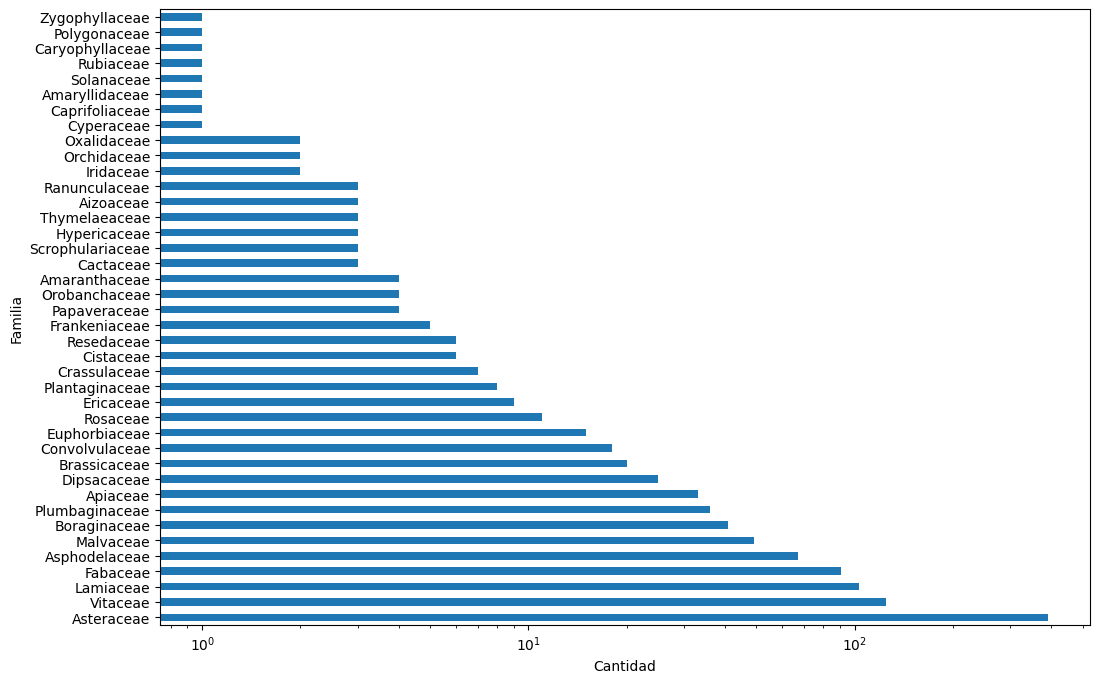

In [17]:
# Grafico de barras horizontal de la columna Familia en escala logaritmica
df['Familia'].value_counts().plot(kind='barh', figsize=(12, 8), logx=True, xlabel='Cantidad', ylabel='Familia')


Cantidad de polinizadores de detección por humanos y por YOLOv5:

<AxesSubplot: xlabel='Cantidad', ylabel='Categoría'>

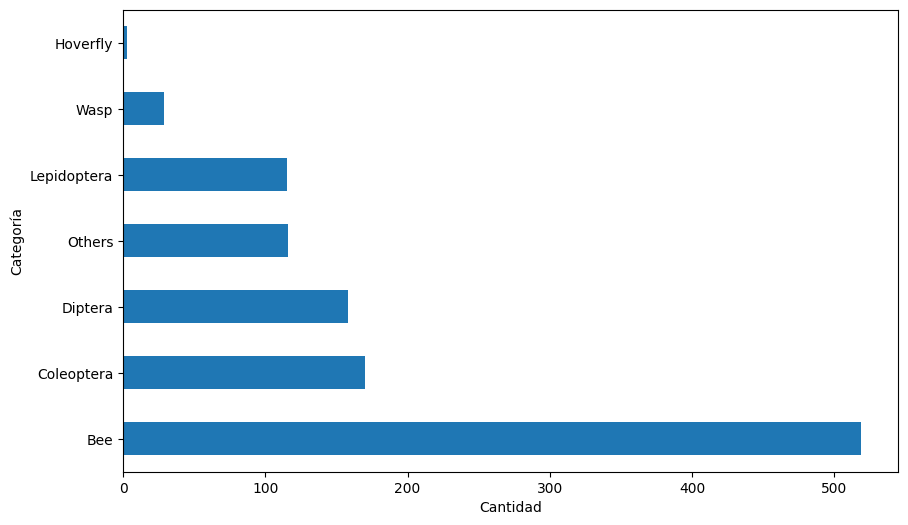

In [21]:
# Grafico de barras horizontal de la columna categoria
df['categoría'].value_counts().plot(kind='barh', figsize=(10, 6), xlabel='Cantidad', ylabel='Categoría')

<AxesSubplot: xlabel='Cantidad', ylabel='Detección'>

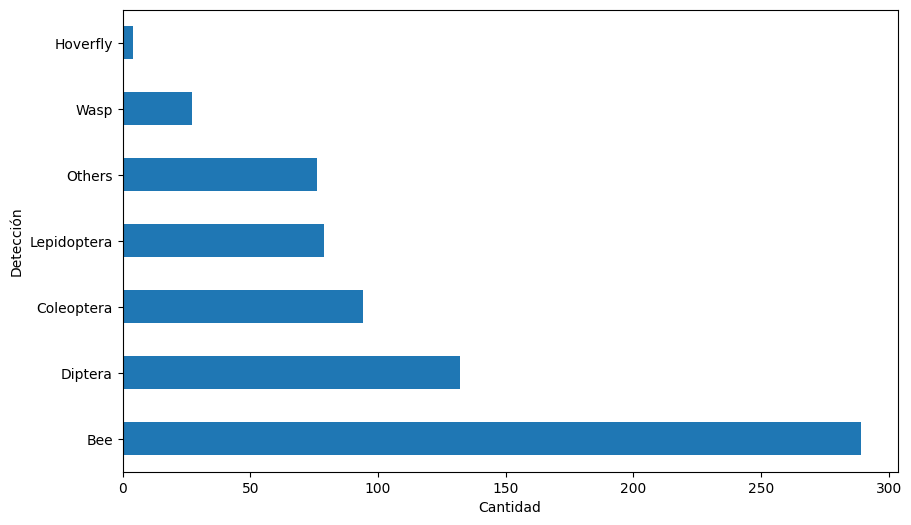

In [27]:
# Grafico de barras horizontal de la columna Detección filtrada si la categoría no_detection
df[df['deteccion'] != 'no_detection']['deteccion'].value_counts().plot(kind='barh', figsize=(10, 6), xlabel='Cantidad', ylabel='Detección')

## Generación de la matriz de adyacencia

Generamos la matriz de interacciones entre plantas y polinizadores.

In [4]:
# Genero la matriz de incidencia en test
M_test = pd.crosstab(df['Familia'], df['categoría'], margins=True)
# Eliminio la fila y columna All
M_test = M_test.drop('All', axis=0)
M_test = M_test.drop('All', axis=1)
display(M_test.head())
print(M_test.shape)
# Genero la matriz de incidencia en detección
M_det = pd.crosstab(df['Familia'], df['deteccion'], margins=True)
M_det = M_det.drop('no_detection', axis=1)
# Eliminio la fila y columna All
M_det = M_det.drop('All', axis=0)
M_det = M_det.drop('All', axis=1)
display(M_det.head())
print(M_det.shape)
# Nombres de indices
index_names_test = M_test.index
index_names_det = M_det.index
# Nombres de columnas
column_names_test = M_test.columns
column_names_det = M_det.columns
# Transformo el dataframe en un array manteniendo el orden
M_test = M_test.to_numpy()
n_p = M_test.shape[0]
n_a = M_test.shape[1]
M_det = M_det.to_numpy()

categoría,Bee,Coleoptera,Diptera,Hoverfly,Lepidoptera,Others,Wasp
Familia,,,,,,,
Aizoaceae,3,0,0,0,0,0,0
Amaranthaceae,3,0,1,0,0,0,0
Amaryllidaceae,0,0,1,0,0,0,0
Apiaceae,1,2,7,0,0,23,0
Asphodelaceae,55,7,4,0,0,0,1


(40, 7)


deteccion,Bee,Coleoptera,Diptera,Hoverfly,Lepidoptera,Others,Wasp
Familia,,,,,,,
Aizoaceae,2,0,0,0,0,0,1
Amaranthaceae,2,0,1,0,0,0,0
Amaryllidaceae,0,0,0,0,0,0,0
Apiaceae,0,0,5,0,0,22,1
Asphodelaceae,43,4,4,0,0,0,2


(40, 7)


Gráficos de matrices de interacciones:

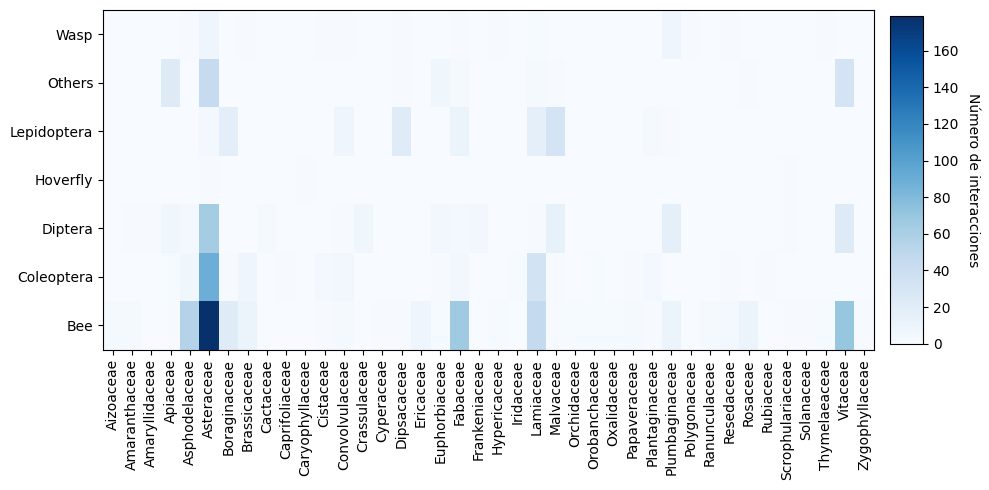

In [8]:
# transpongo 
temp = M_test.T
# Relaciones en test
plt.figure(figsize=(10,5))
plt.pcolormesh(temp, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Número de interacciones', rotation=270)
# coloco en el eje y los nombres index_names_test
plt.xticks(np.arange(M_test.shape[0])+0.5, index_names_test, rotation=90)
# coloco en el eje x los nombres column_names_test
plt.yticks(np.arange(M_test.shape[1])+0.5, column_names_test, rotation=0)
plt.tight_layout()
plt.show()

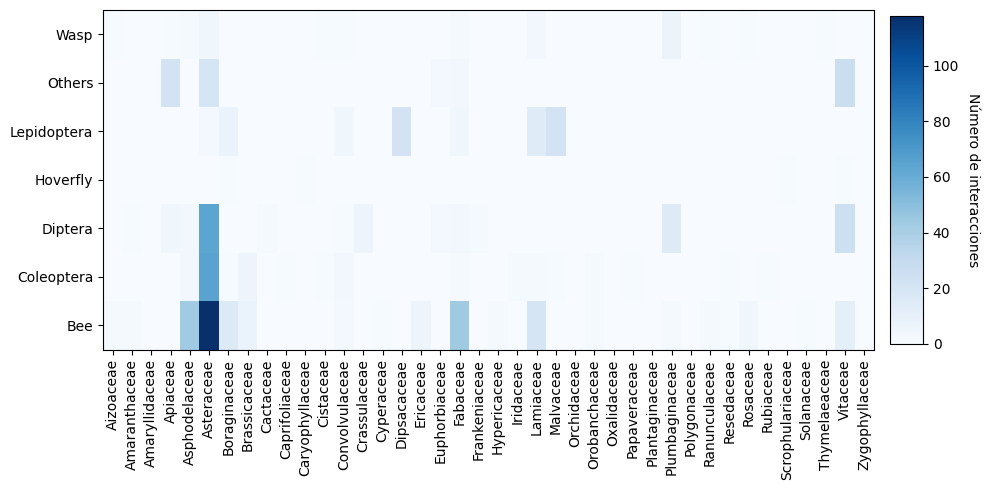

In [10]:
# transpongo 
temp = M_det.T
# Relaciones en detección
plt.figure(figsize=(10,5))
plt.pcolormesh(temp, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Número de interacciones', rotation=270)
# coloco en el eje y los nombres index_names_test
plt.xticks(np.arange(M_det.shape[0])+0.5, index_names_det, rotation=90)
# coloco en el eje x los nombres column_names_test
plt.yticks(np.arange(M_det.shape[1])+0.5, column_names_det, rotation=0)
plt.tight_layout()
plt.show()


## Generación del grafo

In [50]:
model_test = pp.compile_stan_model(M_test, random_seed = 1)
model_det = pp.compile_stan_model(M_det, random_seed = 1)

[Compiling]
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__e8i8gwg/model_26gg5aod.stan', line 45, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/tmp/httpstan__e8i8gwg/model_26gg5aod.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


[Compiling]
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__e8i8gwg/model_26gg5aod.stan', line 45, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/tmp/httpstan__e8i8gwg/model_26gg5aod.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [51]:
samples_test = pp.generate_sample(model_test, num_warmup=2000, num_samples=500)
samples_det = pp.generate_sample(model_det, num_warmup=2000, num_samples=500)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000926 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000614 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (101/10000)
Sampling:   2% (200/10000)
Sampling:   3% (300/10000)
Sampling:   4% (400/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampli

In [52]:
M_test_tilde = pp.get_posterior_predictive_matrix(samples_test)
M_det_tilde = pp.get_posterior_predictive_matrix(samples_det)

In [53]:
edge_prob_test = pp.estimate_network(samples_test)
edge_prob_det = pp.estimate_network(samples_det)

Guardamos las matrices de probabilidades de adyacencia en un archivo.

In [55]:
# prompt: guardo en un csv las matrices edge_prob_test y edge_prob_det
pd.DataFrame(edge_prob_test).to_csv('edge_prob_test.csv', index=False)
pd.DataFrame(edge_prob_det).to_csv('edge_prob_det.csv', index=False)
